In [1]:
# %pip install metaknowledge
# %pip install community
# %pip install nltk
# %pip install spacy
# %pip install gensim
# %pip install pyLDAvis
# %pip install seaborn

In [1]:
# %pip install metaknowledge # ensure Internet setting is "On" 
import os
import pandas as pd
import numpy as np
import random
from random import sample
from itertools import chain

import metaknowledge as mk
import networkx as nx
import community
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import spacy
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import ldamodel
from gensim.models import CoherenceModel 
import re
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

%matplotlib inline
import seaborn as sns
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")

c:\Users\ual-laptop\anaconda3\envs\LEADING\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
df = pd.read_csv("data/repositories_core.csv")
keywords = pd.read_csv("data/keywords.csv")
author = pd.read_csv("data/authors.csv")

# df.head(3)

In [3]:
df.info()
df.nunique()
# df['author(s)'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1229 entries, 0 to 1228
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   author(s)             1229 non-null   object
 1   publisher             1229 non-null   object
 2   keywords              1229 non-null   object
 3   title                 1229 non-null   object
 4   publicationYear       1229 non-null   int64 
 5   publisher_categories  1229 non-null   object
dtypes: int64(1), object(5)
memory usage: 57.7+ KB


author(s)               1228
publisher                 44
keywords                 300
title                   1207
publicationYear           30
publisher_categories       6
dtype: int64

In [4]:
# Start with keywords
# turn data into network data
#    help: https://towardsdatascience.com/from-dataframe-to-network-graph-bbb35c8ab675

#set our empty graph
# G = nx.Graph()

# turn our keywords and their links into an edgelist
# keywords_publisher = nx.from_pandas_adjacency() #check the types of arguments that go here
keywords_ptopic = nx.from_pandas_edgelist(keywords, 'keywords', 'publisher_categories')
print(keywords_ptopic)
kpt = nx.to_networkx_graph(keywords_ptopic)


Graph with 203 nodes and 273 edges


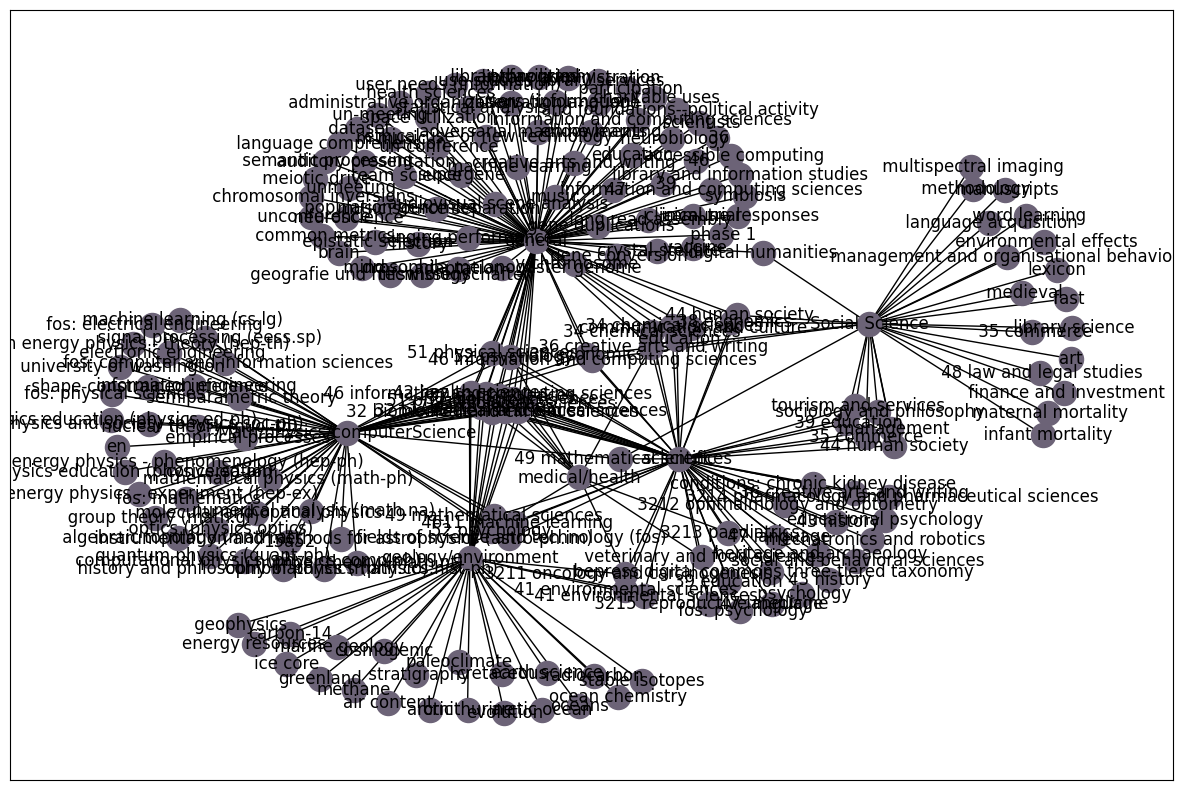

In [33]:
# test data to make sure it's in network form
# it is but it's very messay and hard to read
# figure(figsize=(15, 10))
# nx.draw_shell(keywords_ptopic,  with_labels=True)
# nx.draw_kamada_kawai(keywords_ptopic,  with_labels=True)
# nx.draw_networkx(keywords_ptopic, pos=nx.kamada_kawai_layout(keywords_ptopic), node_color = "#6c6377") #node_color = ['#1f78b4', "#f4141c", "#08a4a7", "#6c6377", "#73a3c1"]

In [5]:
#Now let's actually see the connections between keywords and their links

# initiate the table
leaderboard = {}
# get each keyword connection
for x in keywords_ptopic.nodes:
 # see the length of the number of keywords included
 leaderboard[x] = len(keywords_ptopic[x])
 
def visualize_table(leaderboard, Title, top_n):
 # create a table to visualize
 s = pd.Series(leaderboard, name=Title)
 df2 = s.to_frame().sort_values(Title, ascending=False)
 display(df2.head(top_n))
#  return df2.head(top_n)

visualize_table(leaderboard, "Connections", 6)

,Connections
general,92
scientific,54
Math/physics/computerScience,53
geology/environment,34
Social Science,29
medical/health,11


## SPEND ONE MORE DAY ON THIS 
- then begin presentaiton/githun organization
### Maybe switch to R and implement:
- Betweeness/centrality measures for specific nodes??
- find a way to implement subgraphs for each repository topic?
- community detection
- ERGM tutorial  

*C:\Users\ual-laptop\OneDrive - University of Arizona\Documents\GDrive_January2023\Semesters\Social_Network_analysis\SOC 526 SP21 101 - 5192021 - 947 AM-002.zip*

*C:\Users\ual-laptop\OneDrive - University of Arizona\Documents\GDrive_January2023\Semesters\Computer\2021_Spring\Network_Analysis*

In [38]:
random.seed(50)

def centrality_msr(Graph, Cfunc, removal_prc = 0.2):

    G = Graph.copy()

### for larger graphs
#to make example faster, remove randomly selected nodes
    num_to_remove = int(len(G)*removal_prc) #remove 20% of the noes for faster 
    print("Removed", num_to_remove, "nodes from graph.")
    nodes = sample(list(G), num_to_remove) #select the nodes to be removed
    G.remove_nodes_from(nodes) #remove the nodes
    print("Node removal now shows", G)

### for all graphs
# get the largest connected component
    components = nx.connected_components(G)
    # print("components", components)
    largest_component = max(components, key = len) #
    H = G.subgraph(largest_component)
    # print("H", H)

# now we can comptute the centrality
    if Cfunc == nx.betweenness_centrality:
        centrality = nx.betweenness_centrality(H, k = 3, endpoints=True)
    #print the centrality measures for each unique keyword/repository topic
    # print(len(centrality))
        visualize_table(centrality, "Betweenness Centrality", 10)
    # print("centrality", centrality)
    elif Cfunc == nx.degree_centrality:
        centrality = nx.degree_centrality(H)
        visualize_table(centrality, "Degree Centrality", 10)
    elif Cfunc == nx.closeness_centrality:
        centrality = nx.closeness_centrality(H)
        visualize_table(centrality, "Closeness Centrality", 10)

#compute community structure
    # returns a dicitonary with a set of nodes for each community
    lpc = nx.community.label_propagation_communities(H)
    # print("label_propagation_communities", lpc)
    #create a dictionary for the index of each community of nodes found in the graph
    community_index = {n: i for i, com in enumerate(lpc) for n in com}
    # print("community index", community_index)

    # return variables for plotting
    return community_index, H, centrality



#### draw graph ####
def plt_centrality(community_index, H, centrality, centrality_measure,  plt_title):
    fig, ax = plt.subplots(figsize=(20, 15))
    pos = nx.spring_layout(H, k=0.15, seed=4572321)
    node_color = [community_index[n] for n in H]
    node_size = [v * 20000 for v in centrality.values()]
    nx.draw_networkx(
        H,
        pos=pos,
        with_labels=True,
        node_color=node_color,
        node_size=node_size,
        edge_color="gainsboro",
        alpha=0.4,
    )

# Title/legend
    font = {"color": "k", "fontsize": 22} #"fontweight": "bold",
    ax.set_title(plt_title, font)
# Change font color for legend
    font["color"] = "r"

    ax.text(
        0.80,
        0.10,
        "node color = community structure",
        horizontalalignment="center",
        transform=ax.transAxes,
        fontdict=font,
    )
    ax.text(
        0.80,
        0.06,
        f"node size = {centrality_measure}",
        horizontalalignment="center",
        transform=ax.transAxes,
        fontdict=font,
    )

# Resize figure for label readability
    ax.margins(0.1, 0.05)
    fig.tight_layout()
    plt.axis("off")
    plt.show()



### Degree Centrality
In networks, degree is the number of connections a node has (non-directed). When calculating the degree centrality we look at the number of connection a node have over all the nodes that exist in the network. In this case degree centrality means that he number of conections a node has makes that node more important.

$degree\_centrality = d_v/(|N| - 1)$, where d_v is the Degree of a node, v, and N is the set of all nodes in the graph. 

Here we see that the nodes Math/physics/ComputerScience (DC = $degree\_centrality$; DC = 0.42), scientific (DC = .38), geology/environment (DC = .26), Social Science (DC = .22), and medical/health (DC = .08) all have higher degree centrality measures. Meaning these nodes have a lot of connections.

Graph with 203 nodes and 273 edges
Removed 40 nodes from graph.
Node removal now shows Graph with 163 nodes and 143 edges


,Degree Centrality
Math/physics/computerScience,0.419048
scientific,0.380952
geology/environment,0.257143
Social Science,0.228571
medical/health,0.076190
31 biological sciences,0.038095
32 biomedical and clinical sciences,0.038095
32 biomedical and clinical sciences,0.038095
31 biological sciences,0.038095
46 information and computing sciences,0.028571


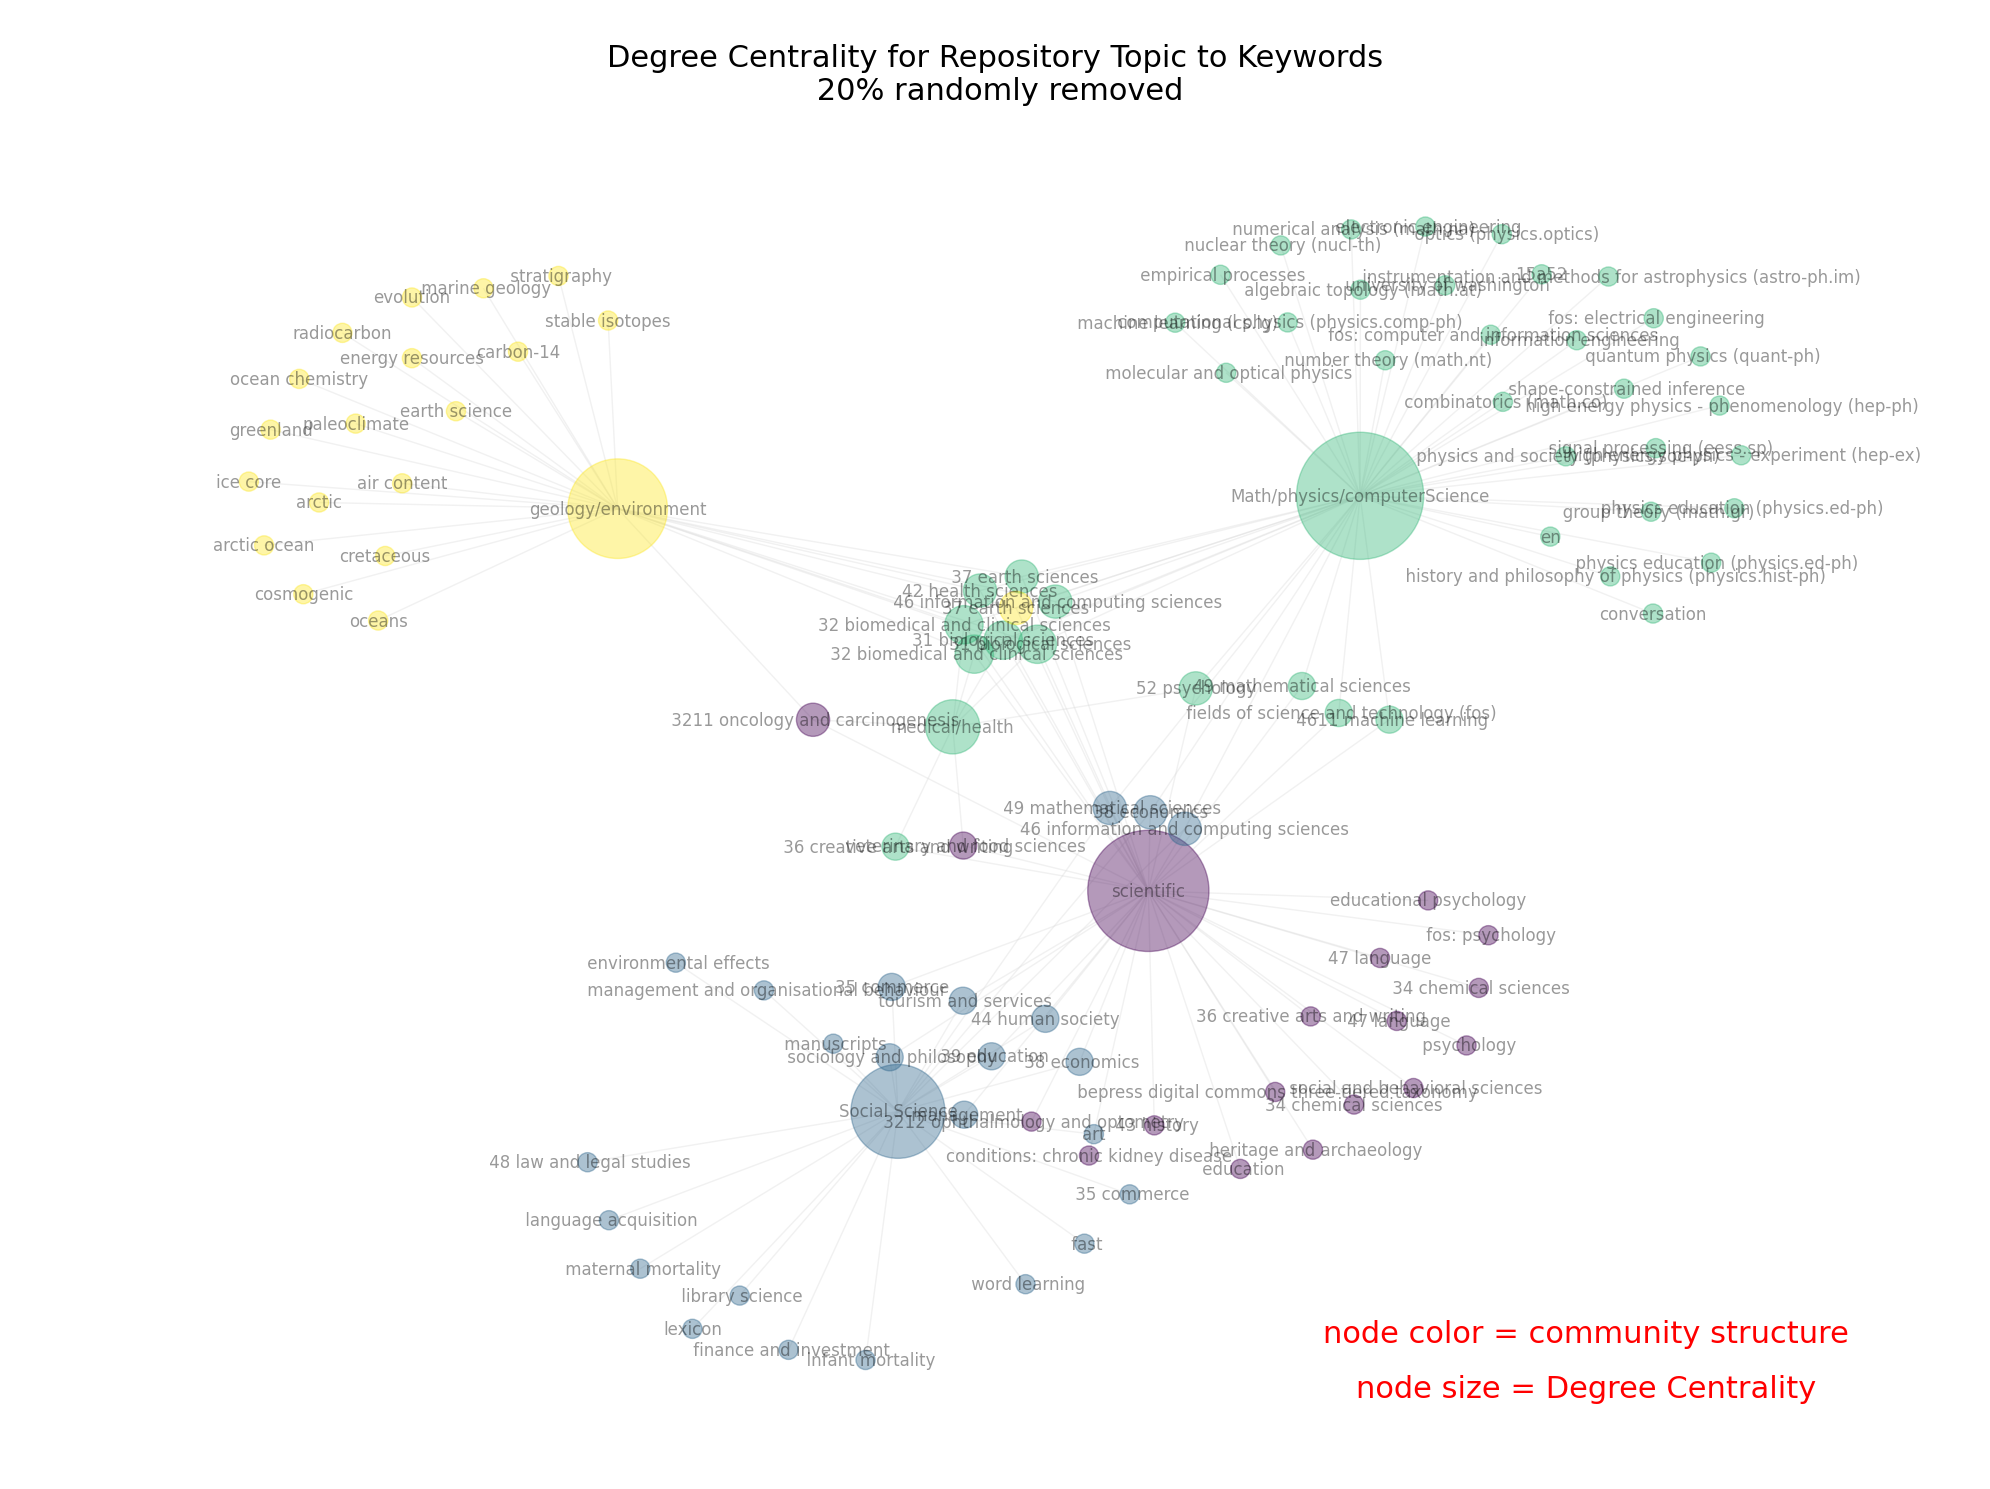

In [39]:
# node_list = keywords['publisher_categories'].unique()
# print(node_list)
keywords_ptopic = nx.from_pandas_edgelist(keywords, 'keywords', 'publisher_categories')
print(keywords_ptopic)
Dcommunity_index, dH, Dcentrality = centrality_msr(keywords_ptopic, nx.degree_centrality)
plt_centrality(Dcommunity_index, dH, Dcentrality, "Degree Centrality", "\nDegree Centrality for Repository Topic to Keywords\n 20% randomly removed")


### Betweenness Centrality

Here we look at the number of nodes our current node of interest is between. It assumes that important nodes are between many nodes and node pairings, meaning that these nodes provide a high number of connections to other nodes in the network.  

$Betweenness\_Centrality = \sum_{s,teN}(\sigma_{s,t}(v)/\sigma_{x,t})$ Here, $\sigma_{s,t}$ represetnts the number of shortest paths between nodes s and t that pass through our node of interest v. $eN$ is the number of node pairs which can differ depending on directed or undirected graphs.

Usually the betweenness centrality for large graphs is high so we normalize the the value by dividing by the number of node pairs (excluding our node of interest). 

Our keyword network shows that the nodes Math/physics/computerScience (BC = $Betweenness\_Centrality$; BC = .055), scientific (BC = .47), 31 biological sciences (BC = 36), sociology and philosophy (BC = .34), and signal processing (BC = .34) have the highest Betweenness Centrality of the network, meaning these nodes are helpful in connecting other nodes to each other.

Removed 40 nodes from graph.
Node removal now shows Graph with 163 nodes and 135 edges


,Betweenness Centrality
Math/physics/computerScience,0.551347
scientific,0.470779
31 biological sciences,0.358709
sociology and philosophy,0.344276
signal processing (eess.sp),0.340067
Social Science,0.180856
geology/environment,0.177489
49 mathematical sciences,0.049169
46 information and computing sciences,0.049169
38 economics,0.049169


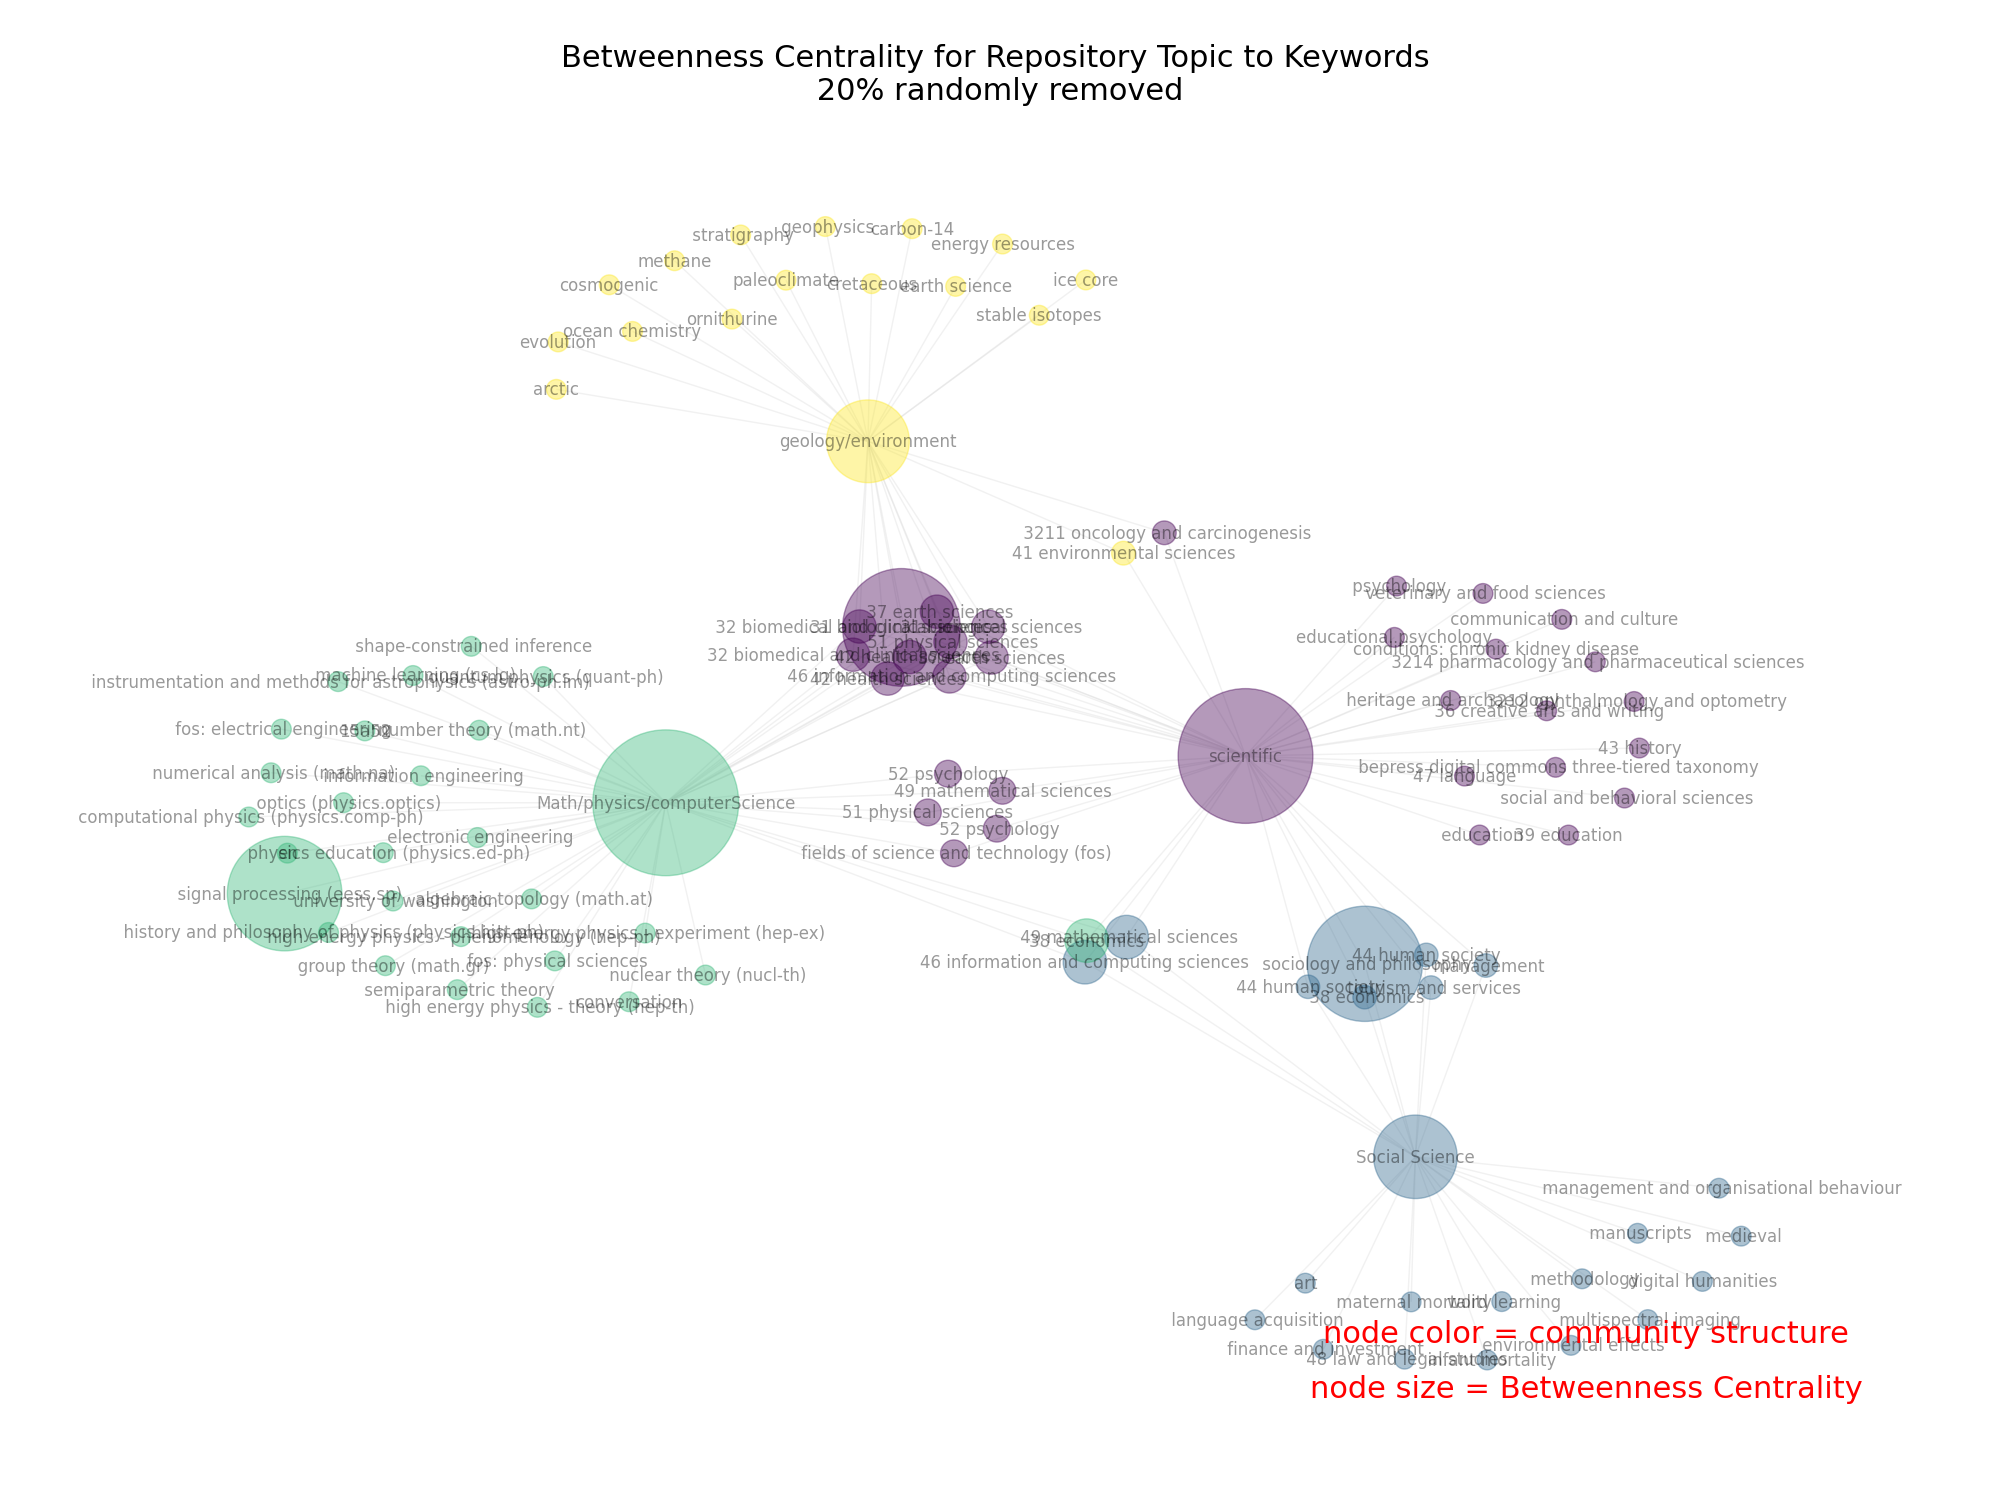

In [40]:

Bcommunity_index, bH, Bcentrality = centrality_msr(keywords_ptopic, nx.betweenness_centrality)
plt_centrality(Bcommunity_index, bH, Bcentrality, "Betweenness Centrality", "\nBetweenness Centrality for Repository Topic to Keywords\n 20% randomly removed")


### Closeness Centrality

Here we're trying to find how close a node is to other nodes. For example, what is the path from our current node of interest to all other nodes? If the path length is short to many nodes then the current node of interest is close to many nodes. The assumption here is that important nodes are close to other nodes. Here we calculate it by taking the sum of the path lengths from our given node to all other nodes. 

For a node that doesn't reach all other nodes in the network (which is our case),

$Closeness\_Centrality = (|R(v)|/|N| - 1) * (|R(v)/ \sum_{ueR(v)}d(v,u))$, here R(v) is the set of all reachable nodes by our current node of interest, v. $d(v,u)$ is all the node pair paths in the network.

Here we see that the nodes: general (CC = $Closeness\_Centrality$; CC = 0.51), 46 information and computing sciences (CC = 0.51), 38 economics	(CC = 0.51), 42 health sciences	(CC = 0.46), and 52 psychology (CC = 0.46) are closest to most other nodes in the network.

What interesting here is that there are multiple nodes with the same CC measure meaning that are all potentially connected to each other in their own subgroups.

Removed 40 nodes from graph.
Node removal now shows Graph with 163 nodes and 192 edges


,Closeness Centrality
general,0.505226
46 information and computing sciences,0.505226
38 economics,0.505226
42 health sciences,0.463259
52 psychology,0.463259
32 biomedical and clinical sciences,0.463259
31 biological sciences,0.463259
31 biological sciences,0.463259
32 biomedical and clinical sciences,0.463259
37 earth sciences,0.460317


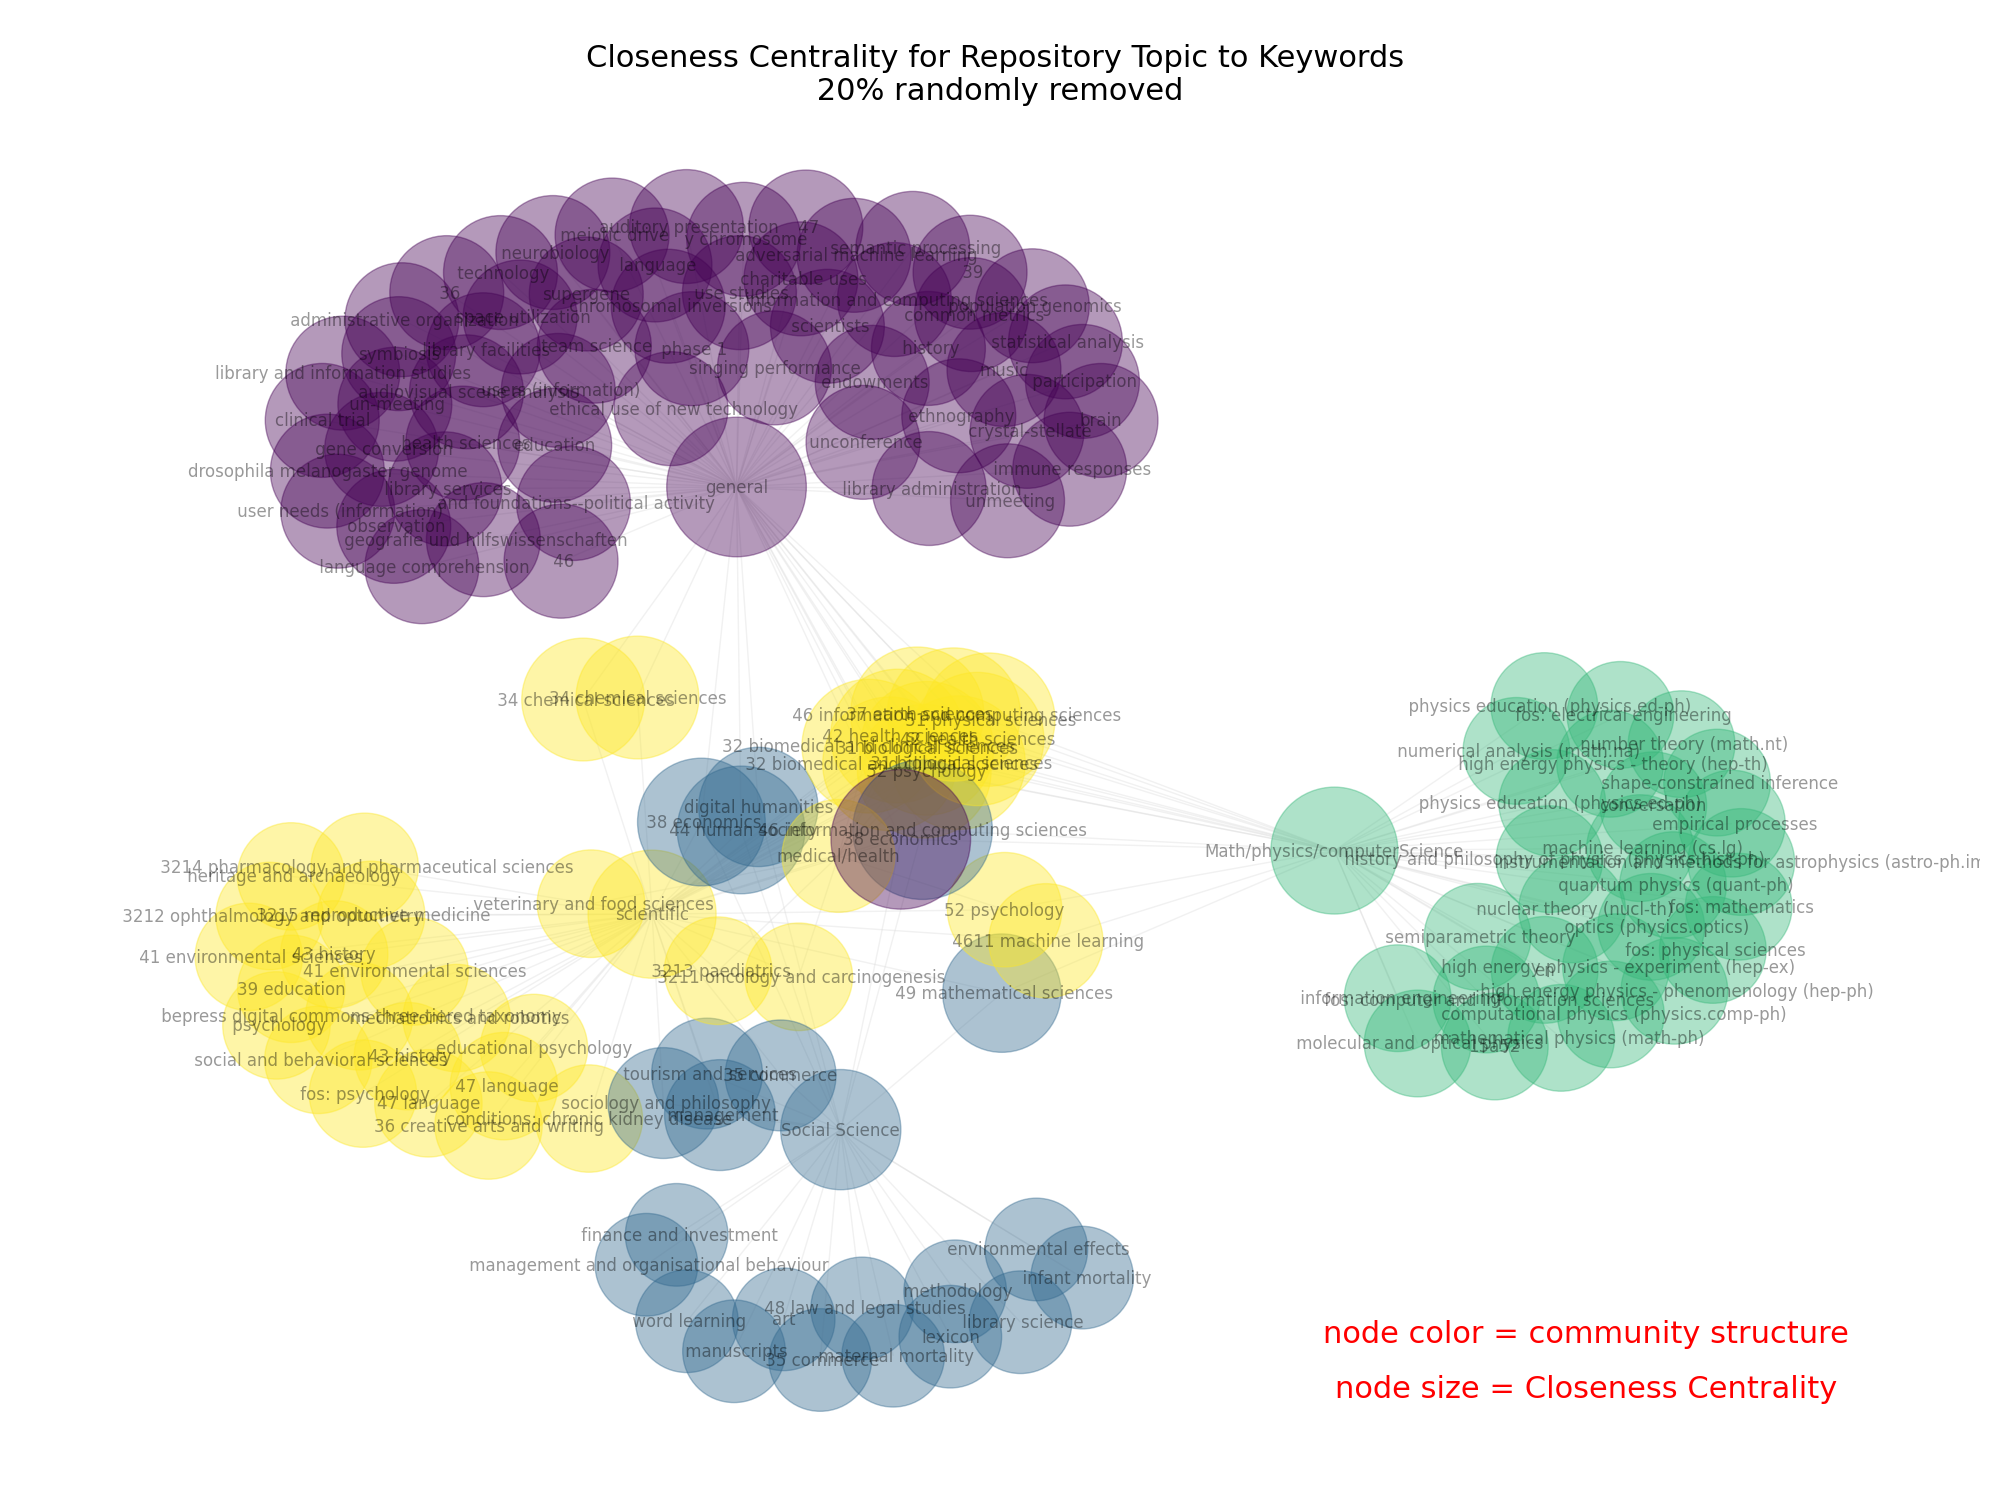

In [42]:
Ccommunity_index, cH, Ccentrality = centrality_msr(keywords_ptopic, nx.closeness_centrality)
plt_centrality(Ccommunity_index, cH, Ccentrality, "Closeness Centrality", "\nCloseness Centrality for Repository Topic to Keywords\n 20% randomly removed")



ERGM

"...how can we know how our observed network density compares to chance?" 

"With ERGMs, we ask: given a sample of networks with like characteristics as the observed network (g(y)), what is the likelihood that these simulations produce the observed network? ... we can compare the observed network statistics with statistics from simulated networks with like characteristics."

**Network density** is the ratio of the number of edges to the maximum possible number of edges


<details>
Quote from: https://medium.com/@ben.roston/exponential-random-graph-models-ergms-network-analysis-and-you-2d7d756345e8

</details>
